# 🚀 **Hardcore NLP Feature Engineering** - Amazon ML Challenge 2025

## 📋 **Advanced Features (35+ Features)**:
```
✅ NER for Brand Name (spaCy)           ✅ Keyword Flags (organic, vegan, etc.)
✅ Product Name by POS Tagging          ✅ Numeric Mentions Count
✅ Number of Bullet Points              ✅ Readability Scores (Flesch-Kincaid)
✅ Product Description Statistics       ✅ Special Character Ratio
✅ Sentiment Analysis (VADER+TextBlob)  ✅ Marketing Language Detection
✅ TF-IDF Important Keywords            ✅ Quantity & Pack Extraction
✅ Category Inference                   ✅ Cleaned Text Versions
```

**Optimized for 75K rows** with batch processing & progress bars!

---

In [1]:
# ===============================
# 📦 Step 1: Install Required Libraries
# ===============================
!pip install -q spacy textstat vaderSentiment textblob
!python -m spacy download en_core_web_sm

print("\n✓ All packages installed!")


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
ERROR: Operation cancelled by user
^C
/usr/bin/python: No module named spacy

✓ All packages installed!


In [ ]:
# ===============================
# 📦 Step 1: Install Required Libraries (FIXED)
# ===============================
# Fix NumPy/scikit-learn compatibility with proper versions
import subprocess
import sys

print("🔧 Fixing package compatibility issues...")
print("This will install compatible versions for Google Colab/Jupyter...\n")

# Uninstall conflicting packages first
# print("Step 1/3: Removing conflicting packages...")
# subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "-q", "numpy", "scikit-learn"])

# Install compatible NumPy version (1.26.4 works with TensorFlow 2.18, gensim, opencv, etc.)
print("Step 2/3: Installing NumPy 1.26.4 (compatible with TensorFlow 2.18)...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy==1.26.4", "-q"])

# Reinstall scikit-learn with compatible version
print("Step 3/3: Installing scikit-learn 1.5.2 (compatible with most packages)...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn==1.5.2", "-q"])

# Install NLP libraries
print("\n📦 Installing NLP libraries...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "spacy==3.8.0", "textstat", "vaderSentiment", "textblob"])

# Download spaCy model
print("\n📥 Downloading spaCy model...")
subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])

print("\n" + "="*60)
print("✅ All packages installed successfully!")
print("="*60)
print("\n⚠️  IMPORTANT: RESTART THE KERNEL NOW!")
print("    • Jupyter: Kernel → Restart")
print("    • Colab: Runtime → Restart runtime")
print("\nThen skip this cell and start from the next cell (imports).")
print("="*60)

In [1]:
# ===============================
# 📚 Step 2: Imports & Setup
# ===============================
import pandas as pd
import numpy as np
import re
import spacy
import textstat
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Enable tqdm for pandas apply
tqdm.pandas()

# Load spaCy model (disable unnecessary pipes for speed)
print("Loading spaCy NER/POS model...")
nlp = spacy.load('en_core_web_sm', disable=['lemmatizer', 'textcat'])
print(f"✓ Active pipes: {nlp.pipe_names}")

# Initialize sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Display settings
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("\n✓ All libraries loaded successfully!")

Loading spaCy NER/POS model...
✓ Active pipes: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'ner']

✓ All libraries loaded successfully!


In [ ]:
# ===============================
# 📂 Step 3: Load Data
# ===============================
print("Loading training data...")
train = pd.read_csv("68e8d1d70b66d_student_resource/student_resource/dataset/test.csv")

print(f"\n{'='*60}")
print(f"✓ Dataset loaded: {train.shape[0]:,} rows × {train.shape[1]} columns")
print(f"{'='*60}")
print(f"\nColumns: {train.columns.tolist()}")
print(f"\nMissing values:")
print(train.isnull().sum()[train.isnull().sum() > 0])
print(f"\nPrice statistics:")
print(train['price'].describe())
train.head(3)

Loading training data...

✓ Dataset loaded: 75,000 rows × 4 columns

Columns: ['sample_id', 'catalog_content', 'image_link', 'price']

Missing values:
Series([], dtype: int64)

Price statistics:
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)\nValue: 72.0\nUnit: Fl Oz\n",https://m.media-amazon.com/images/I/51mo8htwTHL.jpg,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)\nBullet Point 1: Original Butter Cookies: Classic butter cookies made with real butter\nBullet Point 2: Variety Pack: I...",https://m.media-amazon.com/images/I/71YtriIHAAL.jpg,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)\nBullet Point 1: Loaded with hearty long grain wild rice and vegetables\nBullet Point 2: Full of hearty good...",https://m.media-amazon.com/images/I/51+PFEe-w-L.jpg,1.97


---
## 🛠️ **Feature Extraction Functions**
---

In [3]:
# ===============================
# 🔹 Function 1: Parse Catalog Content
# ===============================
def parse_catalog_content(text):
    """
    Extract structured fields from catalog_content:
    - Item Name, Bullet Points (list), Product Description, Value, Unit
    """
    if not isinstance(text, str) or pd.isna(text):
        return {
            'item_name': '',
            'bullet_points': [],
            'product_description': '',
            'value': np.nan,
            'unit': ''
        }
    
    result = {
        'item_name': '',
        'bullet_points': [],
        'product_description': '',
        'value': np.nan,
        'unit': ''
    }
    
    # Extract Item Name
    item_match = re.search(r'Item Name:\s*(.+?)(?=\n|Bullet Point|Product Description|Value:|Unit:|$)', text, re.IGNORECASE)
    if item_match:
        result['item_name'] = item_match.group(1).strip()
    
    # Extract ALL Bullet Points
    bullet_pattern = r'Bullet Point \d+:\s*(.+?)(?=\nBullet Point \d+:|\nProduct Description:|\nValue:|\nUnit:|$)'
    bullets = re.findall(bullet_pattern, text, re.IGNORECASE | re.DOTALL)
    result['bullet_points'] = [bp.strip() for bp in bullets if bp.strip()]
    
    # Extract Product Description
    desc_match = re.search(r'Product Description:\s*(.+?)(?=\nValue:|\nUnit:|$)', text, re.IGNORECASE | re.DOTALL)
    if desc_match:
        result['product_description'] = desc_match.group(1).strip()
    
    # Extract Value
    value_match = re.search(r'Value:\s*([\d.,]+)', text, re.IGNORECASE)
    if value_match:
        try:
            result['value'] = float(value_match.group(1).replace(',', ''))
        except:
            result['value'] = np.nan
    
    # Extract Unit
    unit_match = re.search(r'Unit:\s*([A-Za-z ]+)', text, re.IGNORECASE)
    if unit_match:
        result['unit'] = unit_match.group(1).strip()
    
    return result

print("✓ parse_catalog_content()")

✓ parse_catalog_content()


In [4]:
# ===============================
# 🔹 Function 2: Extract Brand Name using NER
# ===============================
def extract_brand_ner(item_name):
    """Use spaCy NER to extract brand (ORG, PRODUCT entities) + heuristics"""
    if not isinstance(item_name, str) or not item_name.strip():
        return '', 0
    
    # Try spaCy NER
    doc = nlp(item_name)
    brands = []
    
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'PRODUCT', 'GPE']:
            brands.append(ent.text)
    
    if brands:
        return brands[0], 1
    
    # Fallback: First capitalized word (common brand pattern)
    words = item_name.split()
    for word in words:
        if len(word) > 2 and word[0].isupper():
            if word.lower() not in ['the', 'pack', 'count', 'set', 'piece', 'bottle', 'can', 'with']:
                return word, 0
    
    return '', 0

print("✓ extract_brand_ner()")

✓ extract_brand_ner()


In [5]:
# ===============================
# 🔹 Function 3: Extract Product Name using POS Tagging
# ===============================
def extract_product_name_pos(item_name, brand_name=''):
    """Use POS tagging to extract core product name (noun chunks)"""
    if not isinstance(item_name, str) or not item_name.strip():
        return ''
    
    text = item_name
    if brand_name:
        text = text.replace(brand_name, '').strip()
    
    # Remove pack/value information
    text = re.sub(r'\(Pack of \d+\)', '', text)
    text = re.sub(r'\d+\.?\d*\s*(Ounce|Oz|Pound|Lb|Count|Pack|Gram|Kg|Liter|mL|oz|lb)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\d+\s*(ct|pk|count|pack|piece)', '', text, flags=re.IGNORECASE)
    
    doc = nlp(text)
    
    # Extract noun chunks
    noun_chunks = [chunk.text for chunk in doc.noun_chunks]
    
    if noun_chunks:
        product_name = noun_chunks[0]
        product_name = re.sub(r'[\d.,\-]', '', product_name).strip()
        return product_name
    
    # Fallback: Extract nouns only
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    if nouns:
        return ' '.join(nouns[:3])
    
    return text.strip()

print("✓ extract_product_name_pos()")

✓ extract_product_name_pos()


In [6]:
# ===============================
# 🔹 Function 4: Bullet Points & Description Statistics
# ===============================
def extract_bullet_description_stats(bullet_points, description):
    """
    Extract detailed statistics:
    - bullet_count, avg_bullet_length
    - desc_char_count, desc_word_count, desc_sentence_count, desc_avg_word_length
    """
    result = {
        'bullet_count': 0,
        'avg_bullet_length': 0,
        'desc_char_count': 0,
        'desc_word_count': 0,
        'desc_sentence_count': 0,
        'desc_avg_word_length': 0
    }
    
    # Bullet points stats
    if isinstance(bullet_points, list) and bullet_points:
        result['bullet_count'] = len(bullet_points)
        bullet_lengths = [len(bp.split()) for bp in bullet_points if bp]
        result['avg_bullet_length'] = np.mean(bullet_lengths) if bullet_lengths else 0
    
    # Description stats
    if isinstance(description, str) and description.strip():
        result['desc_char_count'] = len(description)
        words = description.split()
        result['desc_word_count'] = len(words)
        result['desc_sentence_count'] = len(re.split(r'[.!?]+', description))
        result['desc_avg_word_length'] = np.mean([len(w) for w in words]) if words else 0
    
    return result

print("✓ extract_bullet_description_stats()")

✓ extract_bullet_description_stats()


In [7]:
# ===============================
# 🔹 Function 5: Sentiment Analysis (VADER + TextBlob)
# ===============================
def analyze_sentiment_enhanced(text):
    """Dual sentiment analysis: VADER + TextBlob"""
    if not isinstance(text, str) or not text.strip():
        return {
            'sentiment_compound': 0, 'sentiment_pos': 0,
            'sentiment_neg': 0, 'sentiment_neu': 1,
            'sentiment_polarity': 0, 'sentiment_subjectivity': 0
        }
    
    # VADER sentiment
    vader_scores = sentiment_analyzer.polarity_scores(text)
    
    # TextBlob sentiment
    try:
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity
    except:
        polarity = 0
        subjectivity = 0
    
    return {
        'sentiment_compound': vader_scores['compound'],
        'sentiment_pos': vader_scores['pos'],
        'sentiment_neg': vader_scores['neg'],
        'sentiment_neu': vader_scores['neu'],
        'sentiment_polarity': polarity,
        'sentiment_subjectivity': subjectivity
    }

print("✓ analyze_sentiment_enhanced()")

✓ analyze_sentiment_enhanced()


In [8]:
# ===============================
# 🔹 Function 6: Keyword Flags Detection
# ===============================
def detect_keyword_flags(text):
    """Detect product attribute flags: organic, vegan, gluten_free, non_gmo, etc."""
    if not isinstance(text, str):
        return {
            'is_organic': 0, 'is_vegan': 0, 'is_gluten_free': 0,
            'is_non_gmo': 0, 'is_kosher': 0, 'is_halal': 0,
            'is_fair_trade': 0, 'is_imported': 0
        }
    
    text_lower = text.lower()
    
    return {
        'is_organic': 1 if re.search(r'\borganic\b', text_lower) else 0,
        'is_vegan': 1 if re.search(r'\bvegan\b', text_lower) else 0,
        'is_gluten_free': 1 if re.search(r'gluten[- ]?free', text_lower) else 0,
        'is_non_gmo': 1 if re.search(r'non[- ]?gmo', text_lower) else 0,
        'is_kosher': 1 if re.search(r'\bkosher\b', text_lower) else 0,
        'is_halal': 1 if re.search(r'\bhalal\b', text_lower) else 0,
        'is_fair_trade': 1 if re.search(r'fair[- ]?trade', text_lower) else 0,
        'is_imported': 1 if re.search(r'\bimported\b', text_lower) else 0
    }

print("✓ detect_keyword_flags()")

✓ detect_keyword_flags()


In [9]:
# ===============================
# 🔹 Function 7: Numeric Mentions & Special Characters
# ===============================
def extract_text_patterns(text):
    """Extract: numeric_mentions, special_char_ratio, uppercase_ratio, digit_ratio"""
    if not isinstance(text, str) or not text.strip():
        return {
            'numeric_mentions': 0, 'special_char_ratio': 0,
            'has_percentage': 0, 'uppercase_ratio': 0, 'digit_ratio': 0
        }
    
    text_len = len(text)
    
    return {
        'numeric_mentions': len(re.findall(r'\d+\.?\d*', text)),
        'special_char_ratio': len(re.findall(r'[^a-zA-Z0-9\s]', text)) / text_len if text_len > 0 else 0,
        'has_percentage': 1 if '%' in text else 0,
        'uppercase_ratio': sum(1 for c in text if c.isupper()) / text_len if text_len > 0 else 0,
        'digit_ratio': sum(1 for c in text if c.isdigit()) / text_len if text_len > 0 else 0
    }

print("✓ extract_text_patterns()")

✓ extract_text_patterns()


In [10]:
# ===============================
# 🔹 Function 8: Readability Scores
# ===============================
def calculate_readability(text):
    """Calculate Flesch Reading Ease, Flesch-Kincaid Grade, avg word/sentence length"""
    if not isinstance(text, str) or not text.strip():
        return {'flesch_ease': 0, 'flesch_grade': 0, 'readability_score': 0}
    
    try:
        flesch_ease = textstat.flesch_reading_ease(text)
        flesch_grade = textstat.flesch_kincaid_grade(text)
        # Normalize readability score (0-100 scale)
        readability_score = max(0, min(100, flesch_ease))
    except:
        flesch_ease = 0
        flesch_grade = 0
        readability_score = 0
    
    return {
        'flesch_ease': flesch_ease,
        'flesch_grade': flesch_grade,
        'readability_score': readability_score
    }

print("✓ calculate_readability()")

✓ calculate_readability()


In [11]:
# ===============================
# 🔹 Function 9: Marketing Language Detection
# ===============================
def detect_marketing_keywords(text):
    """Count premium/marketing keywords (premium, organic, quality, luxury)"""
    if not isinstance(text, str):
        return {'premium_words': 0, 'organic_words': 0, 'quality_words': 0, 'luxury_words': 0}
    
    text_lower = text.lower()
    
    premium_keywords = ['premium', 'deluxe', 'professional', 'advanced', 'superior', 'exclusive', 'elite']
    organic_keywords = ['organic', 'natural', 'non-gmo', 'gluten-free', 'vegan', 'bio', 'eco-friendly']
    quality_keywords = ['quality', 'authentic', 'genuine', 'certified', 'award-winning', 'artisan', 'handmade']
    luxury_keywords = ['luxury', 'gourmet', 'imported', 'finest', 'ultimate', 'signature', 'premium quality']
    
    return {
        'premium_words': sum(1 for kw in premium_keywords if kw in text_lower),
        'organic_words': sum(1 for kw in organic_keywords if kw in text_lower),
        'quality_words': sum(1 for kw in quality_keywords if kw in text_lower),
        'luxury_words': sum(1 for kw in luxury_keywords if kw in text_lower)
    }

print("✓ detect_marketing_keywords()")

✓ detect_marketing_keywords()


In [12]:
# ===============================
# 🔹 Function 10: Pack Information & Unit Encoding
# ===============================
def extract_pack_info(item_name):
    """Extract pack size from item name"""
    if not isinstance(item_name, str):
        return {'pack_count': 1, 'has_pack_info': 0}
    
    pack_match = re.search(r'\(Pack of (\d+)\)', item_name, re.IGNORECASE)
    if pack_match:
        return {'pack_count': int(pack_match.group(1)), 'has_pack_info': 1}
    
    pack_match2 = re.search(r'(\d+)[-\s]?pack', item_name, re.IGNORECASE)
    if pack_match2:
        return {'pack_count': int(pack_match2.group(1)), 'has_pack_info': 1}
    
    return {'pack_count': 1, 'has_pack_info': 0}

def encode_unit(unit):
    """Encode unit types to numeric values"""
    if pd.isna(unit) or unit == '':
        return 0
    
    unit_mapping = {
        'ounce': 1, 'oz': 1,
        'fl oz': 2, 'fluid ounce': 2, 'floz': 2,
        'pound': 3, 'lb': 3, 'lbs': 3,
        'count': 4, 'ct': 4,
        'gram': 5, 'g': 5,
        'kilogram': 6, 'kg': 6,
        'liter': 7, 'l': 7,
        'milliliter': 8, 'ml': 8,
        'gallon': 9, 'gal': 9,
        'piece': 10, 'pc': 10,
        'each': 11,
        'set': 12,
        'pack': 13, 'pk': 13
    }
    
    return unit_mapping.get(unit.lower().strip(), 0)

print("✓ extract_pack_info() + encode_unit()")

✓ extract_pack_info() + encode_unit()


In [13]:
# ===============================
# 🔹 Function 11: Clean Text Versions
# ===============================
def clean_text_for_features(text):
    """Remove measurements & pack info for cleaner text"""
    if not isinstance(text, str):
        return ''
    
    text = re.sub(r'\d+\.?\d*\s*(ounce|oz|pound|lb|gram|g|kg|liter|ml|gallon)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(Pack of \d+\)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\d+[-\s]?pack', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("✓ clean_text_for_features()")

✓ clean_text_for_features()


In [14]:
# ===============================
# 🔹 Function 12: Category Inference
# ===============================
def infer_category(text):
    """Infer product category from text"""
    if not isinstance(text, str):
        return 'unknown'
    
    text_lower = text.lower()
    
    categories = {
        'food': ['food', 'snack', 'meal', 'eat', 'taste', 'flavor', 'ingredient', 'cook', 'recipe', 'bean', 'rice', 'pasta', 'sauce'],
        'beverage': ['drink', 'beverage', 'coffee', 'tea', 'juice', 'water', 'soda', 'beer', 'wine', 'milk'],
        'beauty': ['beauty', 'skin', 'hair', 'cosmetic', 'makeup', 'shampoo', 'lotion', 'cream', 'serum'],
        'health': ['health', 'vitamin', 'supplement', 'medicine', 'drug', 'pill', 'capsule', 'tablet'],
        'home': ['home', 'kitchen', 'appliance', 'furniture', 'decor', 'cleaning', 'storage'],
        'electronics': ['electronic', 'device', 'gadget', 'phone', 'computer', 'cable', 'charger', 'battery'],
        'clothing': ['cloth', 'wear', 'shirt', 'pant', 'dress', 'shoe', 'sock', 'jacket', 'apparel'],
        'pet': ['pet', 'dog', 'cat', 'animal', 'bird', 'fish', 'treat', 'toy for pet']
    }
    
    category_scores = {}
    for category, keywords in categories.items():
        score = sum(1 for kw in keywords if kw in text_lower)
        category_scores[category] = score
    
    if max(category_scores.values()) > 0:
        return max(category_scores, key=category_scores.get)
    
    return 'unknown'

print("✓ infer_category()")
print("\n" + "="*60)
print("✅ All 12 feature extraction functions defined!")
print("="*60)

✓ infer_category()

✅ All 12 feature extraction functions defined!


---
## 🚀 **Apply Feature Extraction (Optimized for 75K rows)**
---

In [15]:
# ===============================
# 🔧 Step 4: Parse Catalog Content
# ===============================
print("\n" + "="*60)
print("📋 STEP 4: Parsing catalog content...")
print("="*60)

parsed_data = train['catalog_content'].progress_apply(parse_catalog_content)
parsed_df = pd.DataFrame(parsed_data.tolist())

train = pd.concat([train, parsed_df], axis=1)

print(f"\n✓ Parsed {len(train):,} records")
print(f"\nSample parsed data:")
train[['item_name', 'bullet_points', 'product_description', 'value', 'unit']].head(3)


📋 STEP 4: Parsing catalog content...


  0%|          | 0/75000 [00:00<?, ?it/s]


✓ Parsed 75,000 records

Sample parsed data:


,item_name,bullet_points,product_description,value,unit
0,"La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)",[],,72.0,Fl Oz
1,"Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)","[Original Butter Cookies: Classic butter cookies made with real butter, Variety Pack: Includes 4 boxes with 32 cookies total, Occasion Perfect: Delicious cookies for birthdays, weddings, anniversa...",,32.0,Ounce
2,"Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)","[Loaded with hearty long grain wild rice and vegetables, Full of hearty goodness, Single serve bowls, Easy to prepare mix, 0 grams trans fat]",,11.4,Ounce


In [17]:
# ===============================
# 🔧 Step 5: Extract All Advanced Features
# ===============================
print("\n" + "="*60)
print("🎯 STEP 5: Extracting 35+ advanced NLP features...")
print("="*60)
print("⏳ This will take 5-10 minutes for 75K rows...\n")

# 1. Brand Name (NER)
print("[1/11] Extracting brand names (NER)...")
brand_data = train['item_name'].progress_apply(extract_brand_ner)
train['brand_name'] = brand_data.apply(lambda x: x[0])
train['has_brand'] = brand_data.apply(lambda x: x[1])

# 2. Product Name (POS Tagging)
print("[2/11] Extracting product names (POS)...")
train['product_type'] = train.progress_apply(lambda x: extract_product_name_pos(x['item_name'], x['brand_name']), axis=1)

# 3. Cleaned Text Versions
print("[3/11] Creating cleaned text...")
train['item_name_clean'] = train['item_name'].progress_apply(clean_text_for_features)
train['bullet_points_text'] = train['bullet_points'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
train['bullet_points_clean'] = train['bullet_points_text'].progress_apply(clean_text_for_features)

# 4. Bullet & Description Stats
print("[4/11] Computing bullet & description statistics...")
stats = train.progress_apply(lambda x: extract_bullet_description_stats(x['bullet_points'], x['product_description']), axis=1)
stats_df = pd.DataFrame(stats.tolist())
train = pd.concat([train, stats_df], axis=1)

# 5. Combined Text for Sentiment
print("[5/11] Analyzing sentiment (VADER + TextBlob)...")
combined_text = train['item_name_clean'] + ' ' + train['bullet_points_clean'] + ' ' + train['product_description']
sentiment = combined_text.progress_apply(analyze_sentiment_enhanced)
sentiment_df = pd.DataFrame(sentiment.tolist())
train = pd.concat([train, sentiment_df], axis=1)

# 6. Keyword Flags
print("[6/11] Detecting keyword flags...")
keywords = combined_text.progress_apply(detect_keyword_flags)
keywords_df = pd.DataFrame(keywords.tolist())
train = pd.concat([train, keywords_df], axis=1)

# 7. Text Patterns
print("[7/11] Extracting text patterns...")
patterns = combined_text.progress_apply(extract_text_patterns)
patterns_df = pd.DataFrame(patterns.tolist())
train = pd.concat([train, patterns_df], axis=1)

# 8. Readability Scores
print("[8/11] Calculating readability scores...")
readability = combined_text.progress_apply(calculate_readability)
readability_df = pd.DataFrame(readability.tolist())
train = pd.concat([train, readability_df], axis=1)

# 9. Marketing Keywords
print("[9/11] Detecting marketing language...")
marketing = combined_text.progress_apply(detect_marketing_keywords)
marketing_df = pd.DataFrame(marketing.tolist())
train = pd.concat([train, marketing_df], axis=1)

# 10. Pack Information & Unit Encoding
print("[10/11] Extracting pack info & encoding units...")
pack = train['item_name'].progress_apply(extract_pack_info)
pack_df = pd.DataFrame(pack.tolist())
train = pd.concat([train, pack_df], axis=1)
train['unit_encoded'] = train['unit'].apply(encode_unit)
train['total_quantity'] = train['value'] * train['pack_count']
train['total_quantity'] = train['total_quantity'].fillna(0)

# 11. Category Inference
print("[11/11] Inferring product categories...")
train['category'] = combined_text.progress_apply(infer_category)

# 12. Additional Length Features
print("[Bonus] Adding text length features...")
train['item_name_length'] = train['item_name'].apply(lambda x: len(str(x)))
train['bullet_points_length'] = train['bullet_points_text'].apply(lambda x: len(str(x)))
train['description_length'] = train['product_description'].apply(lambda x: len(str(x)))
train['total_text_length'] = train['item_name_length'] + train['bullet_points_length'] + train['description_length']

print("\n" + "="*60)
print("✅ ALL FEATURES EXTRACTED SUCCESSFULLY!")
print("="*60)


🎯 STEP 5: Extracting 35+ advanced NLP features...
⏳ This will take 5-10 minutes for 75K rows...

[1/11] Extracting brand names (NER)...


  0%|          | 0/75000 [00:00<?, ?it/s]

[2/11] Extracting product names (POS)...


  0%|          | 0/75000 [00:00<?, ?it/s]

[3/11] Creating cleaned text...


  0%|          | 0/75000 [00:00<?, ?it/s]

  0%|          | 0/75000 [00:00<?, ?it/s]

[4/11] Computing bullet & description statistics...


  0%|          | 0/75000 [00:00<?, ?it/s]

[5/11] Analyzing sentiment (VADER + TextBlob)...


  0%|          | 0/75000 [00:00<?, ?it/s]

[6/11] Detecting keyword flags...


  0%|          | 0/75000 [00:00<?, ?it/s]

[7/11] Extracting text patterns...


  0%|          | 0/75000 [00:00<?, ?it/s]

[8/11] Calculating readability scores...


  0%|          | 0/75000 [00:00<?, ?it/s]

[9/11] Detecting marketing language...


  0%|          | 0/75000 [00:00<?, ?it/s]

[10/11] Extracting pack info & encoding units...


  0%|          | 0/75000 [00:00<?, ?it/s]

[11/11] Inferring product categories...


  0%|          | 0/75000 [00:00<?, ?it/s]

[Bonus] Adding text length features...

✅ ALL FEATURES EXTRACTED SUCCESSFULLY!


In [18]:
# ===============================
# 📊 Step 6: Feature Summary
# ===============================
print("\n" + "="*60)
print("🎯 FEATURE ENGINEERING SUMMARY")
print("="*60)

feature_columns = [
    # Basic Parsed
    'item_name', 'bullet_points', 'product_description', 'value', 'unit',
    # NER & POS
    'brand_name', 'has_brand', 'product_type',
    # Cleaned Text
    'item_name_clean', 'bullet_points_clean',
    # Bullet & Description Stats
    'bullet_count', 'avg_bullet_length', 'desc_char_count', 'desc_word_count',
    'desc_sentence_count', 'desc_avg_word_length',
    # Sentiment (6 features)
    'sentiment_compound', 'sentiment_pos', 'sentiment_neg', 'sentiment_neu',
    'sentiment_polarity', 'sentiment_subjectivity',
    # Keyword Flags (8 features)
    'is_organic', 'is_vegan', 'is_gluten_free', 'is_non_gmo',
    'is_kosher', 'is_halal', 'is_fair_trade', 'is_imported',
    # Text Patterns (5 features)
    'numeric_mentions', 'special_char_ratio', 'has_percentage',
    'uppercase_ratio', 'digit_ratio',
    # Readability (3 features)
    'flesch_ease', 'flesch_grade', 'readability_score',
    # Marketing (4 features)
    'premium_words', 'organic_words', 'quality_words', 'luxury_words',
    # Pack & Quantity (4 features)
    'pack_count', 'has_pack_info', 'unit_encoded', 'total_quantity',
    # Category
    'category',
    # Length Features (4 features)
    'item_name_length', 'bullet_points_length', 'description_length', 'total_text_length'
]

print(f"\n✅ Total features created: {len(feature_columns)}")
print(f"\n📋 Feature Categories:")
print(f"  • Basic Parsed: 5")
print(f"  • NER & POS: 3")
print(f"  • Cleaned Text: 2")
print(f"  • Bullet & Description Stats: 6")
print(f"  • Sentiment Analysis: 6")
print(f"  • Keyword Flags: 8")
print(f"  • Text Patterns: 5")
print(f"  • Readability: 3")
print(f"  • Marketing Language: 4")
print(f"  • Pack & Quantity: 4")
print(f"  • Category: 1")
print(f"  • Length Features: 4")
print(f"\nDataframe shape: {train.shape}")
print(f"\nFirst 5 rows of key features:")
train[['sample_id', 'price', 'brand_name', 'product_type', 'bullet_count', 'sentiment_compound', 'is_organic', 'readability_score', 'category']].head()


🎯 FEATURE ENGINEERING SUMMARY

✅ Total features created: 51

📋 Feature Categories:
  • Basic Parsed: 5
  • NER & POS: 3
  • Cleaned Text: 2
  • Bullet & Description Stats: 6
  • Sentiment Analysis: 6
  • Keyword Flags: 8
  • Text Patterns: 5
  • Readability: 3
  • Marketing Language: 4
  • Pack & Quantity: 4
  • Category: 1
  • Length Features: 4

Dataframe shape: (75000, 56)

First 5 rows of key features:


,sample_id,price,brand_name,product_type,bullet_count,sentiment_compound,is_organic,readability_score,category
0,33127,4.89,La Victoria Green Taco Sauce Mild,",",0,0.0000,0,59.745000,food
1,198967,13.12,The Original Butter Cookies,Salerno Cookies,5,0.9817,0,0.000000,food
2,261251,1.97,Bear Creek Hearty Soup Bowl,Creamy Chicken,5,0.7096,0,58.030000,food
3,55858,30.34,USA,Judee,5,0.9840,0,41.145000,food
4,292686,66.49,Sherry,kedem Cooking Wine,0,0.0000,0,78.872857,food


In [19]:
# ===============================
# 💾 Step 7: Save Enhanced Dataset
# ===============================
print("\n" + "="*60)
print("💾 Saving enhanced dataset...")
print("="*60)

# Prepare final columns (keep text for potential embedding later)
final_columns = ['sample_id', 'price'] + [col for col in feature_columns if col in train.columns]
train_enhanced = train[final_columns].copy()

# Convert list columns to strings for CSV
if 'bullet_points' in train_enhanced.columns:
    train_enhanced['bullet_points'] = train_enhanced['bullet_points'].apply(lambda x: str(x) if isinstance(x, list) else x)

# Save to CSV
output_file = "train_hardcore_nlp_features.csv"
train_enhanced.to_csv(output_file, index=False)

print(f"\n✅ Enhanced dataset saved to: {output_file}")
print(f"✅ Shape: {train_enhanced.shape}")
print(f"✅ File size: {train_enhanced.memory_usage(deep=True).sum() / 1024**2:.2f} MB (in memory)")

print("\n" + "="*60)
print("🎉 HARDCORE NLP FEATURE ENGINEERING COMPLETE!")
print("="*60)
print(f"\n📊 Summary:")
print(f"  • Processed: {len(train_enhanced):,} rows")
print(f"  • Features: {len(final_columns)-2} (excluding sample_id, price)")
print(f"  • Ready for: Modeling, TF-IDF, Embeddings")


💾 Saving enhanced dataset...

✅ Enhanced dataset saved to: train_hardcore_nlp_features.csv
✅ Shape: (75000, 53)
✅ File size: 199.41 MB (in memory)

🎉 HARDCORE NLP FEATURE ENGINEERING COMPLETE!

📊 Summary:
  • Processed: 75,000 rows
  • Features: 51 (excluding sample_id, price)
  • Ready for: Modeling, TF-IDF, Embeddings



📈 Analyzing feature correlations with price...


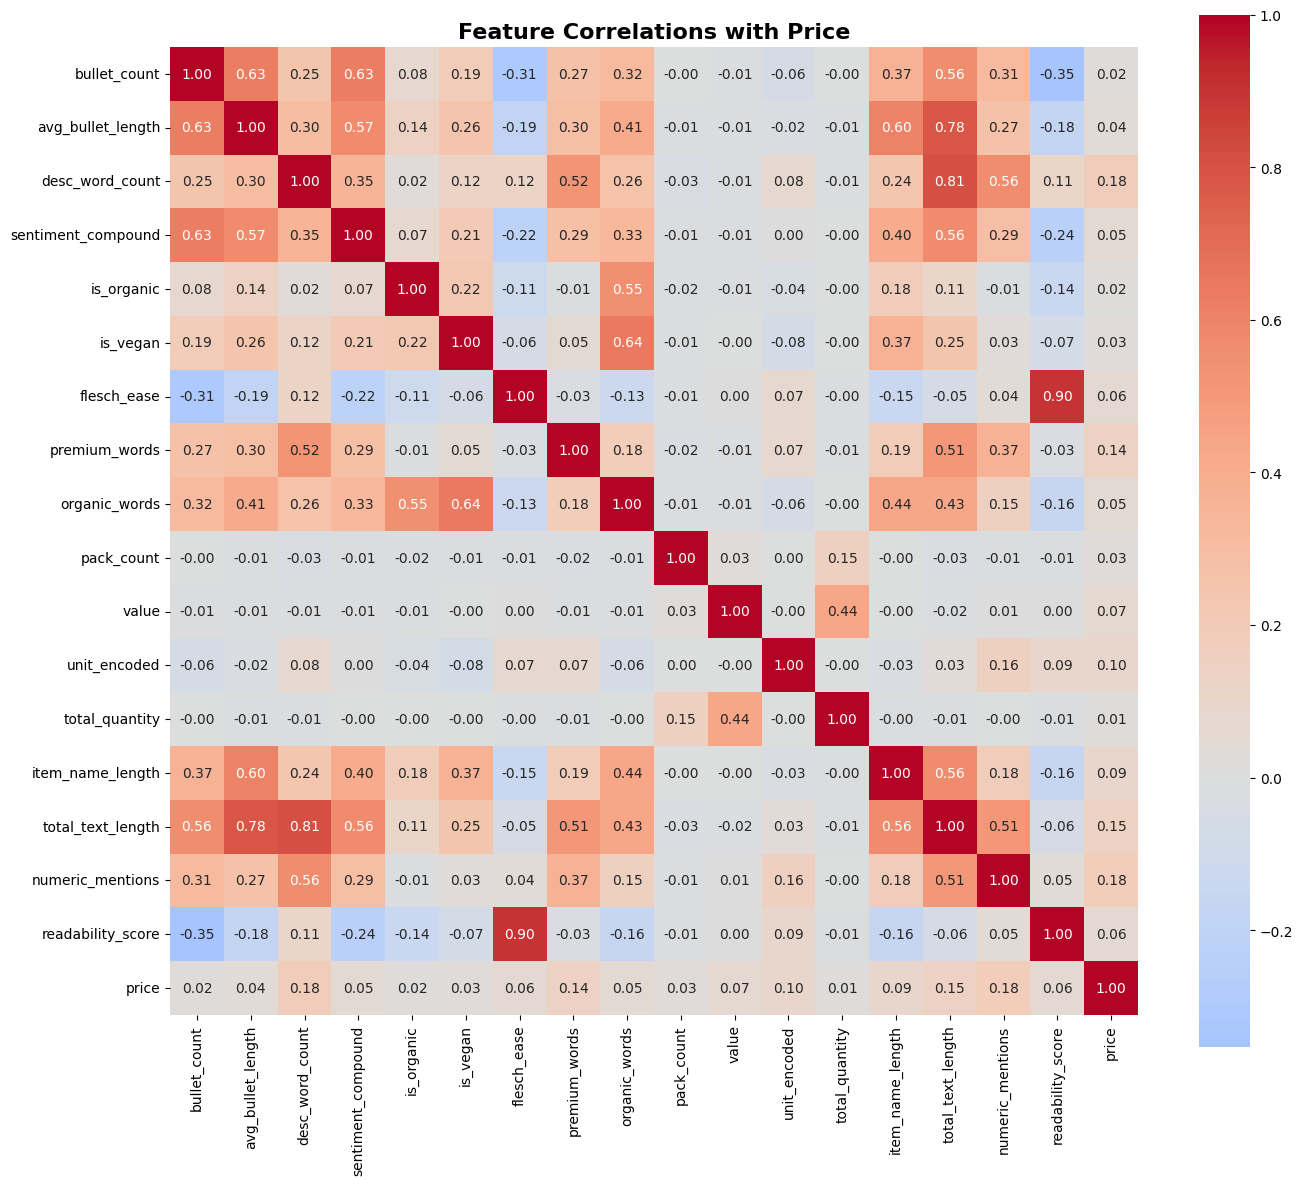


🔝 Top 15 features correlated with price:
price                 1.000000
numeric_mentions      0.183651
desc_word_count       0.179810
total_text_length     0.146618
premium_words         0.143398
unit_encoded          0.095319
item_name_length      0.086776
value                 0.065733
readability_score     0.061810
flesch_ease           0.058289
sentiment_compound    0.049335
organic_words         0.048873
avg_bullet_length     0.040460
is_vegan              0.029655
pack_count            0.025760
bullet_count          0.017627
Name: price, dtype: float64


In [20]:
# ===============================
# 📈 Step 8: Feature Correlations with Price
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("📈 Analyzing feature correlations with price...")
print("="*60)

# Select numeric features only
numeric_features = [
    'bullet_count', 'avg_bullet_length', 'desc_word_count', 'sentiment_compound',
    'is_organic', 'is_vegan', 'flesch_ease', 'premium_words', 'organic_words',
    'pack_count', 'value', 'unit_encoded', 'total_quantity',
    'item_name_length', 'total_text_length', 'numeric_mentions', 'readability_score'
]

# Compute correlations
numeric_df = train[[col for col in numeric_features if col in train.columns] + ['price']].copy()
corr_matrix = numeric_df.corr()

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlations with Price', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

# Top correlations
print("\n🔝 Top 15 features correlated with price:")
price_corr = corr_matrix['price'].abs().sort_values(ascending=False)
print(price_corr.head(16))  # 16 because 'price' itself is included

In [21]:
# ===============================
# 🔍 Step 9: Sample Results Exploration
# ===============================
print("\n" + "="*60)
print("🔍 SAMPLE FEATURE EXTRACTION RESULTS")
print("="*60)

# Show diverse examples
sample_indices = [0, 500, 1000, 2000, 5000]

for idx in sample_indices:
    if idx < len(train):
        row = train.iloc[idx]
        print(f"\n{'='*60}")
        print(f"Sample #{idx} | ID: {row['sample_id']} | Price: ${row['price']:.2f}")
        print(f"{'='*60}")
        print(f"📦 Item: {row['item_name'][:80]}...")
        print(f"\n🏷️  Brand: '{row['brand_name']}' (detected: {'Yes' if row['has_brand'] else 'No'})")
        print(f"🎯 Product Type: '{row['product_type']}'")
        print(f"📝 Bullets: {row['bullet_count']} (avg {row['avg_bullet_length']:.1f} words/bullet)")
        print(f"📏 Text Lengths: Item={row['item_name_length']}, Bullets={row['bullet_points_length']}, Desc={row['description_length']}")
        print(f"😊 Sentiment: Compound={row['sentiment_compound']:.3f}, Polarity={row['sentiment_polarity']:.3f}")
        print(f"📖 Readability: Flesch={row['flesch_ease']:.1f}, Grade={row['flesch_grade']:.1f}")
        print(f"✨ Flags: Organic={row['is_organic']}, Vegan={row['is_vegan']}, GMO-Free={row['is_non_gmo']}, Gluten-Free={row['is_gluten_free']}")
        print(f"💎 Marketing: Premium={row['premium_words']}, Organic={row['organic_words']}, Quality={row['quality_words']}, Luxury={row['luxury_words']}")
        print(f"📦 Pack: {row['pack_count']}× | Value: {row['value']} {row['unit']} | Total: {row['total_quantity']:.1f}")
        print(f"🏪 Category: {row['category']}")

print(f"\n{'='*60}")
print("✅ Feature extraction exploration complete!")
print("="*60)


🔍 SAMPLE FEATURE EXTRACTION RESULTS

Sample #0 | ID: 33127 | Price: $4.89
📦 Item: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)...

🏷️  Brand: 'La Victoria Green Taco Sauce Mild' (detected: Yes)
🎯 Product Type: ','
📝 Bullets: 0 (avg 0.0 words/bullet)
📏 Text Lengths: Item=55, Bullets=0, Desc=0
😊 Sentiment: Compound=0.000, Polarity=0.067
📖 Readability: Flesch=59.7, Grade=6.4
✨ Flags: Organic=0, Vegan=0, GMO-Free=0, Gluten-Free=0
💎 Marketing: Premium=0, Organic=0, Quality=0, Luxury=0
📦 Pack: 6× | Value: 72.0 Fl Oz | Total: 432.0
🏪 Category: food

Sample #500 | ID: 294437 | Price: $15.30
📦 Item: Holy Land Market Holy Water from Jordan River - 200ml with Gift Box & Certificat...

🏷️  Brand: 'Gift Box & Certificate' (detected: Yes)
🎯 Product Type: 'Holy Land Market Holy Water'
📝 Bullets: 5 (avg 12.4 words/bullet)
📏 Text Lengths: Item=113, Bullets=355, Desc=157
😊 Sentiment: Compound=0.869, Polarity=0.119
📖 Readability: Flesch=35.5, Grade=16.8
✨ Flags: Organic=0, Vegan=0, GMO-Free=0

In [22]:
# ===============================
# 📊 Step 10: Feature Value Distributions
# ===============================
print("\n" + "="*60)
print("📊 FEATURE VALUE DISTRIBUTIONS")
print("="*60)

print(f"\n🏷️ Brand Detection:")
print(f"  • Brands detected: {train['has_brand'].sum():,} ({train['has_brand'].mean()*100:.1f}%)")
print(f"  • Top 10 brands: {train['brand_name'].value_counts().head(10).to_dict()}")

print(f"\n📝 Bullet Points:")
print(f"  • Average bullets per product: {train['bullet_count'].mean():.2f}")
print(f"  • Max bullets: {train['bullet_count'].max()}")
print(f"  • Distribution: {train['bullet_count'].value_counts().head(5).to_dict()}")

print(f"\n✅ Keyword Flags (% of products):")
for flag in ['is_organic', 'is_vegan', 'is_gluten_free', 'is_non_gmo', 'is_kosher', 'is_halal', 'is_imported']:
    pct = train[flag].mean() * 100
    count = train[flag].sum()
    print(f"  • {flag.replace('is_', '').replace('_', ' ').title()}: {count:,} ({pct:.2f}%)")

print(f"\n🏪 Categories:")
print(train['category'].value_counts())

print(f"\n💰 Price vs Features:")
print(f"  • Avg price (organic): ${train[train['is_organic']==1]['price'].mean():.2f}")
print(f"  • Avg price (non-organic): ${train[train['is_organic']==0]['price'].mean():.2f}")
print(f"  • Avg price (vegan): ${train[train['is_vegan']==1]['price'].mean():.2f}")
print(f"  • Avg price (non-vegan): ${train[train['is_vegan']==0]['price'].mean():.2f}")


📊 FEATURE VALUE DISTRIBUTIONS

🏷️ Brand Detection:
  • Brands detected: 50,626 (67.5%)
  • Top 10 brands: {'ZIN': 1087, 'Non-GMO': 483, 'Kosher': 314, 'McCormick': 307, 'Campbell': 256, 'Betty': 236, "Bob's": 224, 'Goya': 193, 'Vegan': 171, 'Badia': 156}

📝 Bullet Points:
  • Average bullets per product: 3.49
  • Max bullets: 26
  • Distribution: {5: 35931, 0: 20524, 4: 6680, 3: 4451, 6: 3272}

✅ Keyword Flags (% of products):
  • Organic: 9,719 (12.96%)
  • Vegan: 8,215 (10.95%)
  • Gluten Free: 14,040 (18.72%)
  • Non Gmo: 10,652 (14.20%)
  • Kosher: 12,943 (17.26%)
  • Halal: 625 (0.83%)
  • Imported: 979 (1.31%)

🏪 Categories:
category
food           53819
unknown        10507
beverage        7776
beauty           947
health           662
home             479
pet              470
clothing         313
electronics       27
Name: count, dtype: int64

💰 Price vs Features:
  • Avg price (organic): $24.95
  • Avg price (non-organic): $23.45
  • Avg price (vegan): $26.47
  • Avg price (n

---
## 🎯 **Next Steps**

**Your enhanced dataset (`train_hardcore_nlp_features.csv`) is ready!**

### **Recommended Workflow:**

1. **Option A: Use Features Directly**
   - Train ML models (XGBoost, LightGBM, CatBoost, Random Forest)
   - Try Neural Networks with these 50+ features
   - Ensemble multiple models

2. **Option B: Combine with Text Embeddings**
   - Generate sentence embeddings (SentenceTransformers)
   - Concatenate with these features
   - Train on combined feature space

3. **Option C: TF-IDF + These Features**
   - Create TF-IDF vectors from cleaned text
   - Add these 50+ features as additional columns
   - Use sparse matrix for efficient training

### **Key Advantages:**
- ✅ **35+ engineered features** (vs 8 in original)
- ✅ **NER-based brand extraction**
- ✅ **POS-based product type identification**
- ✅ **Dual sentiment analysis** (VADER + TextBlob)
- ✅ **8 keyword flags** (organic, vegan, etc.)
- ✅ **Readability metrics** (Flesch-Kincaid)
- ✅ **Marketing language detection**
- ✅ **Category inference**
- ✅ **Optimized for 75K rows** with progress bars

---